In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
import joblib
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [2]:
def preprocess(raw_data):
    
    raw_data.iloc[:,   9:189] = raw_data.iloc[:, 9:189].div(raw_data['weight'], axis=0) #normalize all the V colums to weight
    raw_data.iloc[:, 191:371] = raw_data.iloc[:, 191:371].div(raw_data['weight'], axis=0) #normalize all the V colums to weight

    raw_data['gait']=1 #change all string 'walk' to a number 1
    raw_data['Gait']=1 #change all string 'trot' to a number 1

    raw_data.loc[raw_data['speed'] .isin(['Not able to walk', 'no data','no valid trials', np.nan]), 'gait'] = 0 
    raw_data.loc[raw_data['speed'] .isin(['Not able to walk', 'no data','no valid trials', np.nan]), 'speed'] = np.nan

    raw_data.loc[raw_data['Speed'] .isin(['Not able to trot', 'no data','no valid trials', np.nan]), 'Gait'] = 0 
    raw_data.loc[raw_data['Speed'] .isin(['Not able to trot', 'no data','no valid trials', np.nan]), 'Speed'] = np.nan


    #drop object column, which is irrevelant colums to our modles
    raw_data.drop(['dob','forceplate_date'], axis=1, inplace=True)

    raw_data['speed'] = raw_data['speed'].astype(float)
    raw_data['Speed'] = raw_data['Speed'].astype(float)
    
    return raw_data

In [3]:
loca='LF'
raw_data_train = pd.read_csv('raw_data/'+loca+'_train.csv')
raw_data_val = pd.read_csv('raw_data/'+loca+'_val.csv')

data_train = preprocess(raw_data_train)
data_val = preprocess(raw_data_val)



In [4]:
X_train = data_train.drop([loca, 'id'], axis=1)
# X = raw_data.drop(['LF', 'id','gait','Gait'], axis=1)
y_train = data_train[loca]

X_val = data_val.drop([loca, 'id'], axis=1)
# X = raw_data.drop(['LF', 'id','gait','Gait'], axis=1)
y_val = data_val[loca]

# X_train.to_csv('train_processed_simple_imputed.csv', index=False)
# X_val.to_csv('val_processed_simple_imputed.csv', index=False)

## XGBoost Search (unimputed)

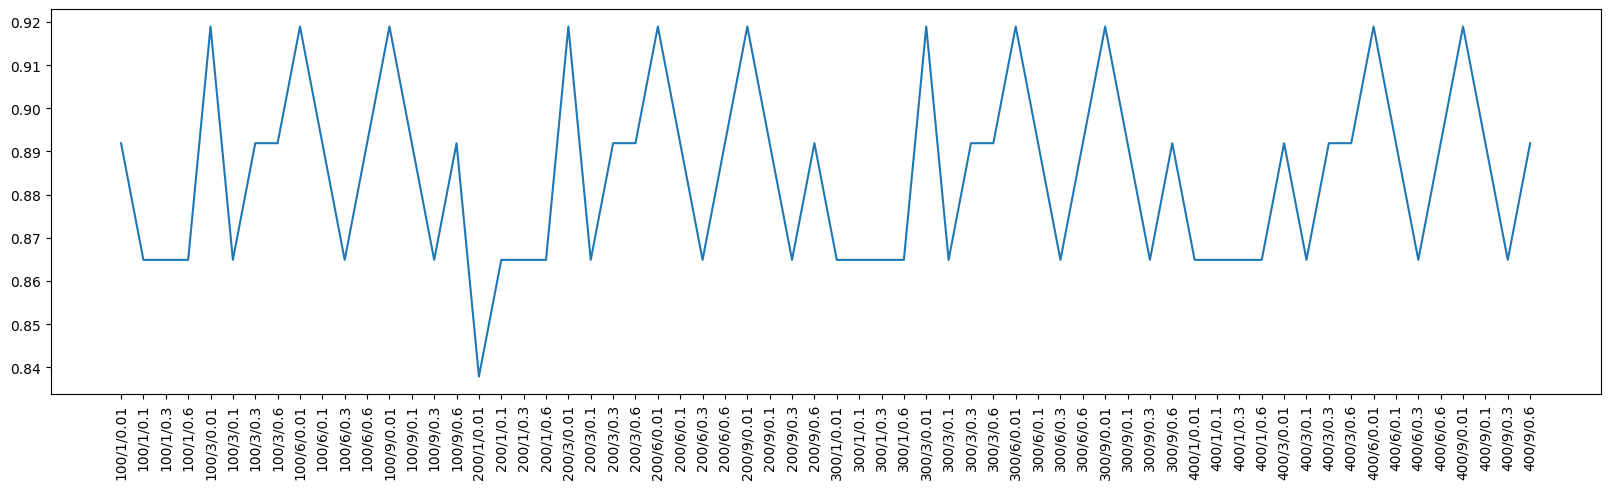

best_acc:0.918918918918919
[400, 9, 0.01]


In [5]:
best_acc=0
progress=0
best_param=[]
pra_list=[]
acc_list=[]
for n_estimators in [100,200,300,400]:
    for max_depth in [1,3,6,9]:
        for learning_rate in [0.01, 0.1,0.3,0.6]:
            progress+=1
#             if progress%10==0:
#                 print(f'Progress:{progress}/{4*4*4}')
            xgb_clf = xgb.XGBClassifier(objective='binary:logistic', max_depth=max_depth,learning_rate=learning_rate,n_estimators=n_estimators)
            xgb_clf.fit(X_train, y_train)
            y_pred = xgb_clf.predict(X_val)
            pra_list.append(f'{n_estimators}/{max_depth}/{learning_rate}')
            acc_list.append(accuracy_score(y_val, y_pred))
            if accuracy_score(y_val, y_pred)>= best_acc:
                best_acc=accuracy_score(y_val, y_pred)
                best_param=[n_estimators,max_depth,learning_rate]
                
plt.figure(figsize=(20, 5))
plt.plot(pra_list, acc_list)
plt.xticks(rotation='vertical')
plt.show()
print(f'best_acc:{best_acc}')
print(best_param)

## Test

In [6]:

raw_data_train = pd.read_csv('raw_data/'+loca+'_train.csv')
raw_data_val = pd.read_csv('raw_data/'+loca+'_test.csv')

data_train = preprocess(raw_data_train)
data_val = preprocess(raw_data_val)

X_train = data_train.drop([loca, 'id'], axis=1)
y_train = data_train[loca]

X_val = data_val.drop([loca, 'id'], axis=1)
y_val = data_val[loca]

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', max_depth=1,learning_rate=0.1,n_estimators=300)
xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)

print(f'acc: {acc}')

acc: 0.918918918918919
